In [55]:
import pandas as pd
import os
import numpy as np
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE,RFECV,SelectKBest
from sklearn.preprocessing import minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc
import seaborn as sns
import matplotlib.pyplot as plt

from cycifsuite.get_data import read_synapse_file
from rfpimp import importances
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature selection based on sampling and emsembling

In [14]:
def data_preprocessing(path, fname, ligand_name=None, sample_size=None, excluding_cells=[]):
    '''Read data and construct
    '''
    imputer = SimpleImputer(strategy='median')
    x = pd.read_hdf(path + fname)
    zero_std_cols = x.columns[x.std() == 0]
    x = x.drop(zero_std_cols, axis=1)
    x.loc[:, :] = imputer.fit_transform(x)

    # Sampling easier feature selection
    if sample_size is not None:
        if isinstance(sample_size, float):
            sample_size = int(sample_size * x.shape[0])
        elif isinstance(sample_size, int):
            pass
        # get rid of cells not wanted
        sample_pool = [k for k in x.index if k not in excluding_cells]
        sample_idx = np.random.choice(
            x.index, size=sample_size)
        x = x.loc[sample_idx]
    # make y_vector
    y_vector = None
    if ligand_name is not None:
        y_vector = [ligand_name] * x.shape[0]
    return x, y_vector

def make_x_and_y(path, feature_files, sample_size=None, norm_func=minmax_scale, binning=False, metadata=None, test_size=None):
    """Read data and sample it at 10%, return data a label
    """
    x = pd.DataFrame()
    y = []
    for fn in feature_files:
        print('processing {}'.format(fn))
        ligand = fn.split('_')[-1][:-4]
        _x, _y = data_preprocessing(
            path, fn, ligand_name=ligand, sample_size=sample_size)
        if binning:
            cm_cells = [k for k in _x.index if k in metadata.index]
            _x = _x.loc[cm_cells].groupby(
                metadata.loc[cm_cells, 'Well']).median()
            _y = [ligand] * _x.shape[0]
        if x.shape[0] == 0:
            x = _x
        else:
            cols = [k for k in x.columns if k in _x.columns]
            x = x[cols].append(_x[cols])
        y += _y
    x.loc[:, :] = norm_func(x)
    if test_size is not None:
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size)
        return x_train, x_test, y_train, y_test
    else:
        return x, y

def selct_k_anova(x,y, num_features):
    # Anova
    sk = SelectKBest(k=num_features)
    sk.fit(x,y)
    sk_fs = sk.get_support()
    sk_fs = x.columns[sk_fs]
    return sk_fs, sk

def ensembled_feature_selection(x_train, y_train, x_test, y_test, num_features=50):
    # Select K best
    print('SelectKbest...')
    sk_fs, _ = selct_k_anova(x_train, y_train, num_features)

    # Random forest
    print('Random forest...')
    full_model = RandomForestClassifier(100)
    full_model.fit(x_train, y_train)
    rf_fi = pd.Series(full_model.feature_importances_, index=x_train.columns)
    rf_fs = rf_fi.sort_values(ascending=False).index[:num_features].tolist()

    # Permutation, out-out-bag based feature importance
    # https://github.com/parrt/random-forest-importances
    rfcv_x_train, rfcv_x_test, rfcv_y_train, rfcv_y_test = train_test_split(
        x_train, y_train, test_size=0.20)
    print('Random forest cv...')
    rfcv = RandomForestClassifier(100, n_jobs=4)
    rfcv.fit(rfcv_x_train, rfcv_y_train)
    rfimp_fi = importances(
        rfcv, rfcv_x_test, pd.Series(rfcv_y_test))  # permutation
    rfpimp_fs = rfimp_fi.index[:num_features].tolist()

    # RFE feature importance with logistic regression and random forest
    print('RFE LR...')
    rfe_input_features = rf_fi.sort_values(ascending=False).index[:500]
    sampled_x = x_train[rfe_input_features]
    sampled_y = y_train
    estimator = estimator = LogisticRegression(
        solver='newton-cg', multi_class='auto')
    selector = RFE(estimator, n_features_to_select=num_features, step=25)
    selector = selector.fit(sampled_x, sampled_y)
    rfe_fs_lr = sampled_x.columns[selector.support_]

    print('RFE RF...')
    estimator = RandomForestClassifier(100)
    selector = RFE(estimator, n_features_to_select=num_features,
                   step=25)
    selector = selector.fit(sampled_x, sampled_y)
    rfe_fs_rf = sampled_x.columns[selector.support_]

    # summerize all features
    feature_ranks = pd.DataFrame(index=x_train.columns)
    for col, fs_list in zip(['Anova', 'RF', 'RF_cv', 'RFE_rf', 'RFE_lr'], 
        [sk_fs, rf_fs, rfpimp_fs, rfe_fs_rf, rfe_fs_lr]):
        feature_ranks.loc[fs_list, col] = 1
    feature_ranks.fillna(0, inplace=True)
    feature_ranks = feature_ranks.sum(axis=1).sort_values(ascending=False)
    feature_ranks = pd.DataFrame(feature_ranks, columns=['feature_rank'])
    feature_ranks['RF_cv_fi'] = rfimp_fi.loc[feature_ranks.index].values
    feature_ranks['RF_fi'] = rf_fi.loc[feature_ranks.index].values
    feature_ranks = feature_ranks.sort_values(
        ['feature_rank', 'RF_cv_fi', 'RF_fi'], ascending=False)
    best_features = feature_ranks.index.tolist()[:num_features]

    # Evaluate best featuers
    feature_acc = pd.Series(index=['Anova', 'RF', 'RF_cv', 'RFE_rf', 'RFE_lr', 'Best', 'Shared >=3', 'Shared >=4'])
    three_abv = feature_ranks[feature_ranks.feature_rank >= 3].index.tolist()
    four_abv = feature_ranks[feature_ranks.feature_rank >= 4].index.tolist()
    for col, fs_list in zip(['Anova', 'RF', 'RF_cv', 'RFE_rf', 'RFE_lr', 'Best', 'Shared >=3', 'Shared >=4'],
                            [sk_fs, rf_fs, rfpimp_fs, rfe_fs_rf, rfe_fs_lr, best_features, three_abv, four_abv]):
        sub_features = fs_list
        x_train_sub = x_train[sub_features]
        x_test_sub = x_test[sub_features]
        fs_model = RandomForestClassifier(100)
        fs_model.fit(x_train_sub, y_train)
        y_pred = fs_model.predict(x_test_sub)
        feature_acc[col] = acc(y_test, y_pred)
    y_pred = full_model.predict(x_test)
    feature_acc['full'] = acc(y_test, y_pred)
    print('Full feature model accuracy {:.2f}'.format(acc(y_test, y_pred)))
    return best_features, rf_fi, rfimp_fi,feature_acc

In [12]:
path = 'd:/data/MCF10A 090718 data/'
feature_files = [x for x in os.listdir(path) if ('plate_6_txt_' in x) and 'all' not in x]
pooled_metadata = pd.read_csv(read_synapse_file('syn17902177'),index_col=0)

Welcome, Yunguan Wang!



In [16]:
num_features = 100
features_df = pd.DataFrame(index = np.arange(10))
for i in range(10):
    print('Iteration ' + str(i+1))
    x_train, x_test, y_train, y_test = make_x_and_y(path,feature_files, sample_size=1500, test_size=0.20)
    best_features, _, _, feature_acc = ensembled_feature_selection(x_train, y_train,x_test,y_test,num_features=num_features)
    features_df.loc[i,'feature_list'] = ','.join(best_features)
    features_df.loc[i,'acc'] = feature_acc['Best']

Iteration 1
processing plate_6_txt_features_BMP2.hdf
processing plate_6_txt_features_EGF.hdf
processing plate_6_txt_features_HGF.hdf
processing plate_6_txt_features_IFNG.hdf
processing plate_6_txt_features_OSM.hdf
processing plate_6_txt_features_PBS.hdf
processing plate_6_txt_features_TGFB.hdf
SelectKbest...
Random forest...
Random forest cv...
RFE LR...
RFE RF...
Full feature model accuracy 0.95
Iteration 2
processing plate_6_txt_features_BMP2.hdf
processing plate_6_txt_features_EGF.hdf
processing plate_6_txt_features_HGF.hdf
processing plate_6_txt_features_IFNG.hdf
processing plate_6_txt_features_OSM.hdf
processing plate_6_txt_features_PBS.hdf
processing plate_6_txt_features_TGFB.hdf
SelectKbest...
Random forest...
Random forest cv...
RFE LR...
RFE RF...
Full feature model accuracy 0.96
Iteration 3
processing plate_6_txt_features_BMP2.hdf
processing plate_6_txt_features_EGF.hdf
processing plate_6_txt_features_HGF.hdf
processing plate_6_txt_features_IFNG.hdf
processing plate_6_txt_fea

In [71]:
from cycifsuite.plate_based_analysis import per_well_analysis
expr_data = x_train.append(x_test)[best_features]
expr_meta = pooled_metadata.loc[expr_data.index]
pba = per_well_analysis(expr_data, expr_meta,output_prefix='Best features', output_path='./')
pba.make_contrast()
pba.contrast_based_distance()
df_dist = pba.df_dist
plt.figure(figsize=(16,9))
sns.violinplot(x='ligand',y='distance',hue='ligand', data=df_dist)
plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.tight_layout()
plt.savefig('Distance to PBS over best features.png')
plt.close()

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



In [72]:
feature_summary = pd.Series(0, index=x_train.columns)
for i in features_df.index:
    features = features_df.loc[i, 'feature_list'].split(',')
    accuracy = features_df.loc[i, 'acc']
    feature_scores = np.arange(100,0,-1)*accuracy
#     feature_scores = accuracy
    feature_summary[features] = feature_summary[features] + feature_scores
feature_summary = feature_summary.sort_values(ascending=False)/1000
feature_summary = feature_summary[feature_summary>0]
best_features = feature_summary.index[:50].tolist()
feature_summary.to_csv('plate_6 features.csv')

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()



In [80]:
len([x for x in feature_summary.index if '_int_' in x])

65

In [81]:
len([x for x in best_features if '_int_' in x])

18

Best feature accuracy RF: 0.9576190476190476


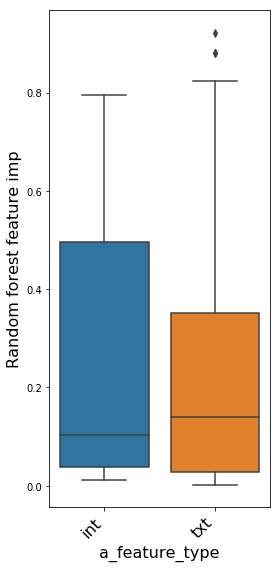

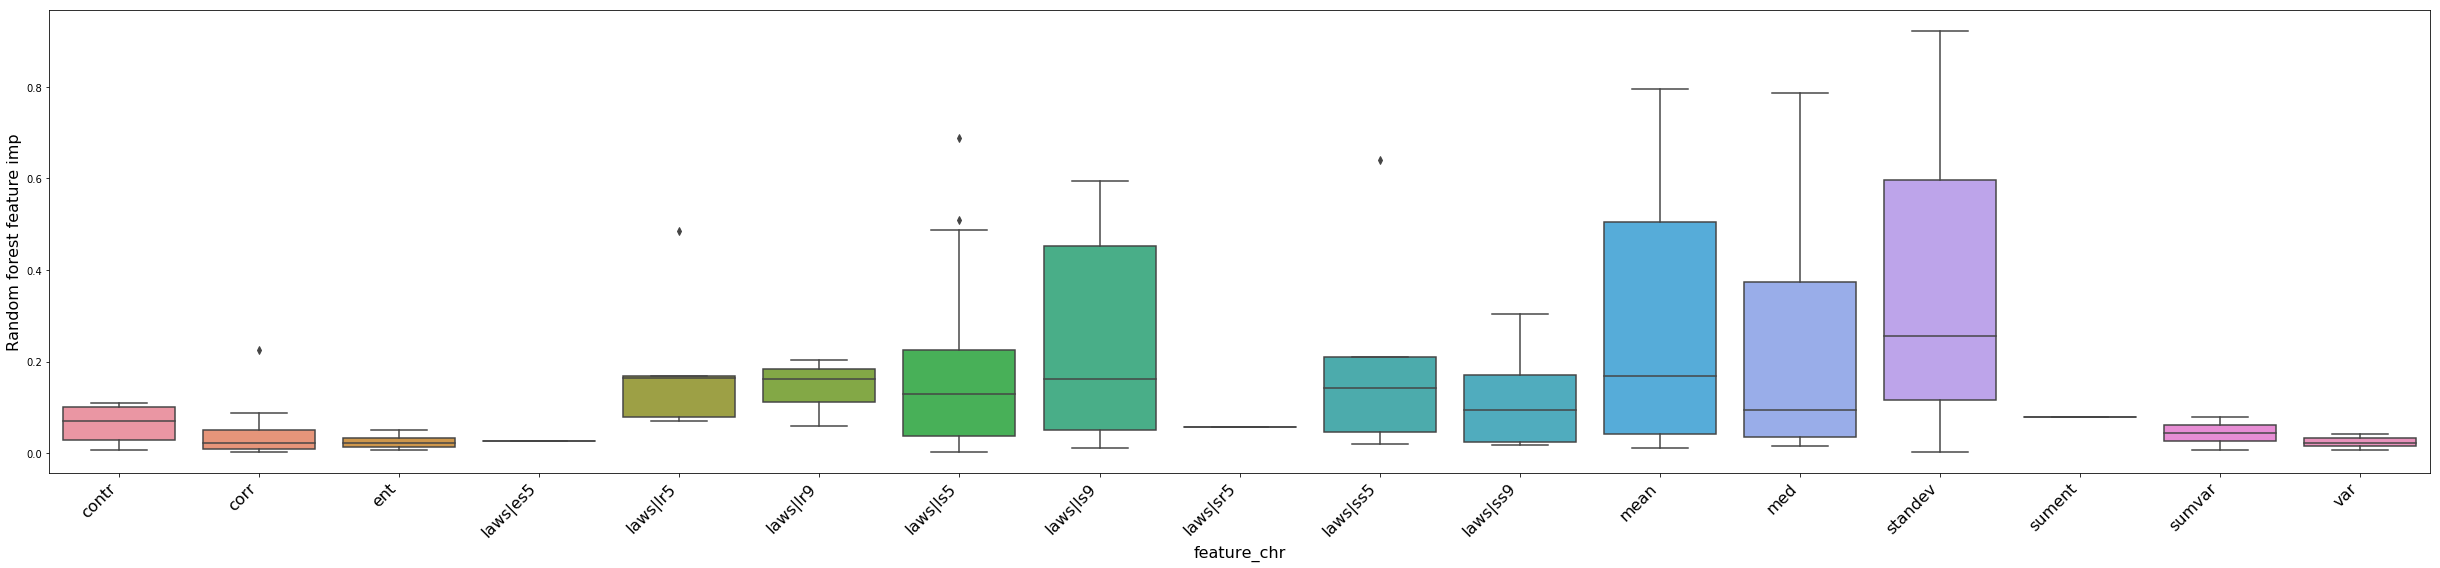

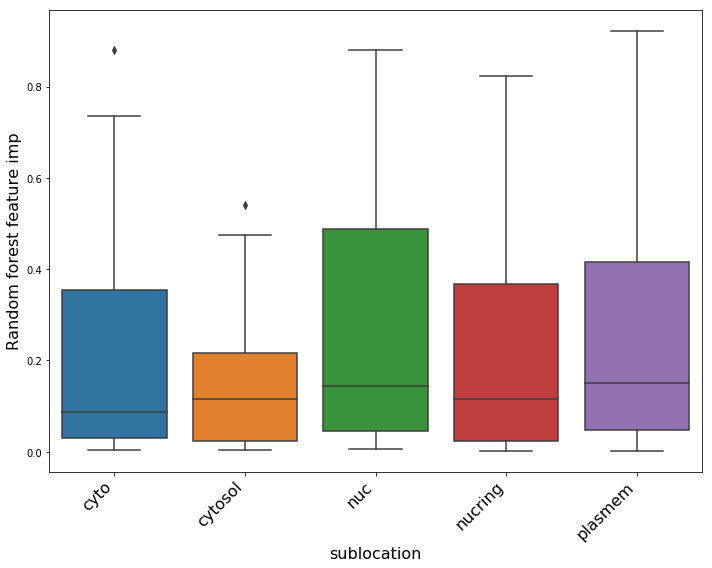

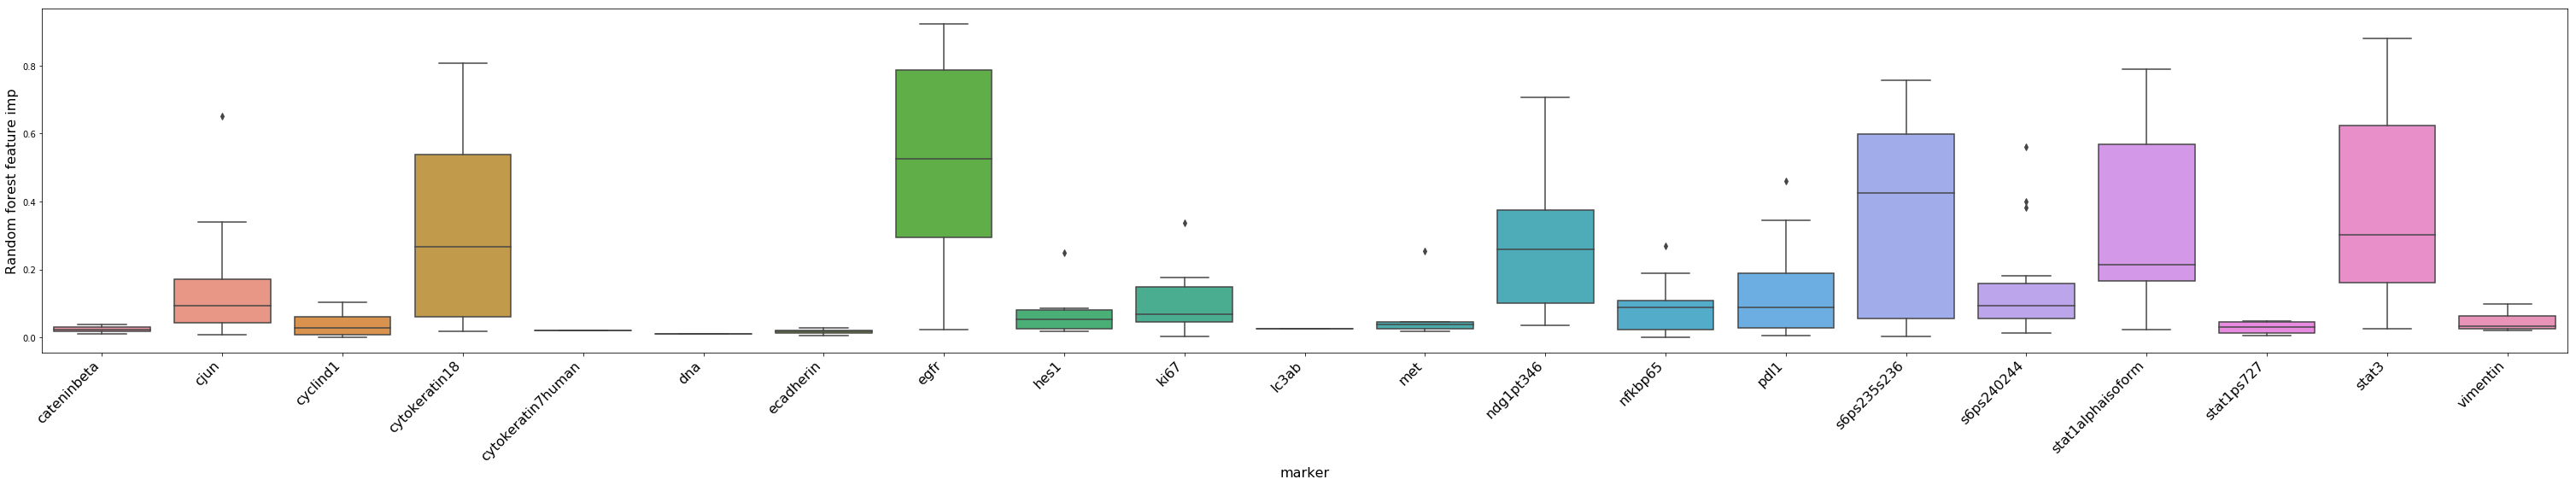

In [64]:
rf = RandomForestClassifier(100)
rf.fit(x_train[best_features], y_train)
y_pred = rf.predict(x_test[best_features])
print('Best feature accuracy RF: {}'.format(acc(y_test, y_pred)))

with open('d:/data/MCF10A 090718 data/feature_metadata.json') as f:
    data=json.load(f)
feature_meta = pd.DataFrame.from_dict(data).transpose()
feature_meta = feature_meta.reindex(feature_summary.index)
fi = feature_summary
feature_meta['imp'] = fi[feature_meta.index]

for fi_meta_type in ['a_feature_type', 'feature_chr', 'sublocation', 'marker']:
    meta_series = feature_meta[fi_meta_type].dropna().sort_values()
    if fi_meta_type == 'marker':
        meta_series[:] = ['dna' if 'dna' in x else x for x in meta_series.values]
    x_axis_len = meta_series.unique().shape[0]
    plt.figure(figsize=(x_axis_len*2, 8))
    sns.boxplot(x=fi_meta_type,y='imp', data=feature_meta.loc[meta_series.index])
    plt.xticks(fontsize=16, rotation=45, ha='right')
    plt.xlabel(fi_meta_type, fontsize=16)
    plt.ylabel('Random forest feature imp', fontsize=16)
    plt.tight_layout()

# Chi square test for enrichment

In [29]:
from scipy.stats import chisquare as chi2
f_ob = len([k for k in best_features if '_int_' in k])
f_ob = [f_ob, len(best_features)-f_ob]
f_exp = len([k for k in x_train.columns if '_int_' in k])
f_exp = [f_exp, x_train.shape[1]-f_exp]
pval = chi2(f_ob, f_exp)[1]
if pval >= 0.05:
    print('Chi-2 test pval: {:.3f}, no enrichment of either class in the best features.'.format(pval))
else:
    print('Chi-2 test pval: {:.3f}, abnormal class distribution in  best features.'.format(pval))
    if f_ob[0]/sum(f_ob)>f_exp[0]/sum(f_exp):
        print('Enrichment of int features observed')
    else:
        print('Enrichment of txt features observed')

Chi-2 test pval: 0.000, abnormal class distribution in  best features.
Enrichment of int features observed


## Permutation based estimate on feature set significance

In [7]:
i=0
random_acc = []
x_train_sub = x_train[best_features]
x_test_sub = x_test[best_features]
fs_model = RandomForestClassifier(100)
fs_model.fit(x_train_sub, y_train)
y_pred = fs_model.predict(x_test_sub)
best_fs_acc = acc(y_test, y_pred)
acc_best_inferior = 0
print('Selected best feature accuracy {:.2f}'.format(acc(y_test, y_pred)))
while i < 100:
    if i%10==0:
        print('iteration {}'.format(i))
    random_features = np.random.choice(x_train.columns, replace=False, size=num_features)
    test_model = RandomForestClassifier(100)
    test_model.fit(x_train[random_features], y_train)
    y_pred = test_model.predict(x_test[random_features])
    random_fs_acc = acc(y_test, y_pred)
    if random_fs_acc>=best_fs_acc:
        print('Randomly selected feature accuracy: {:.2f}'.format(random_fs_acc))
        acc_best_inferior+=1
    random_acc.append(random_fs_acc)
    i+=1
print('Pval of best feature : {}'.format(acc_best_inferior/100))

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



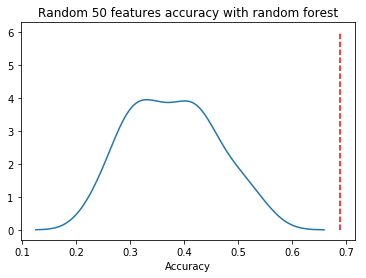

In [11]:
g = sns.kdeplot(random_acc)
plt.plot([best_fs_acc,best_fs_acc], [0,6], c='red',linestyle='--')
plt.title('Random 50 features accuracy with random forest')
plt.xlabel('Accuracy')
plt.savefig('Random 50 features accuracy with random forest.png')